C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Processing data and collecting stats...


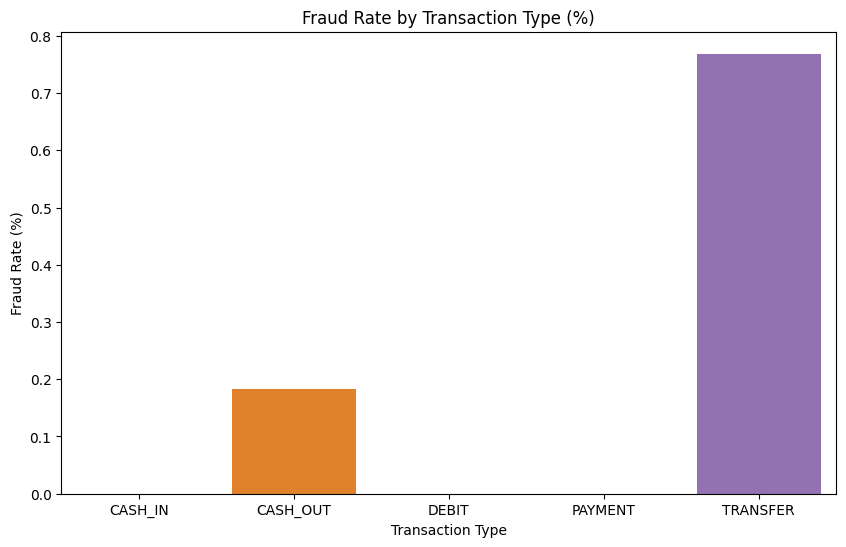

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


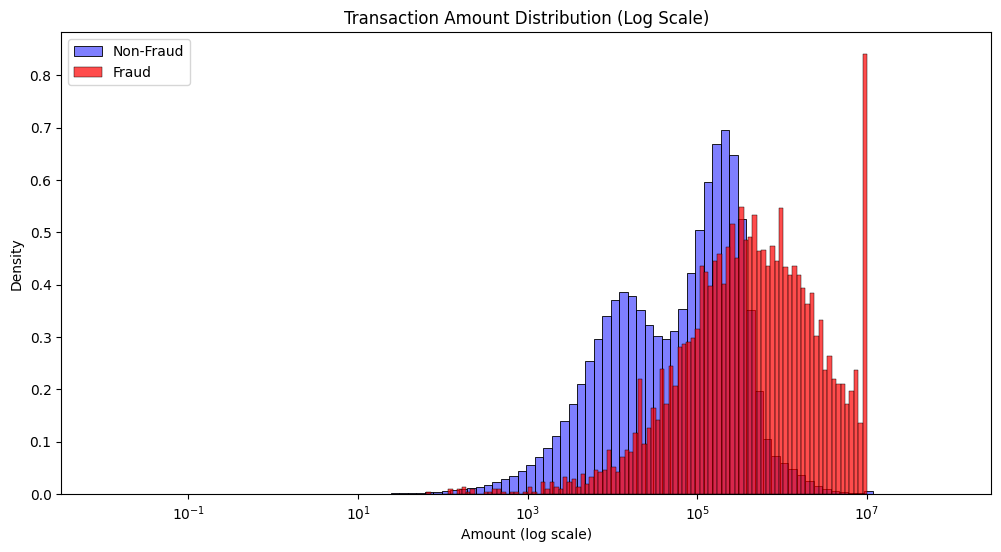

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

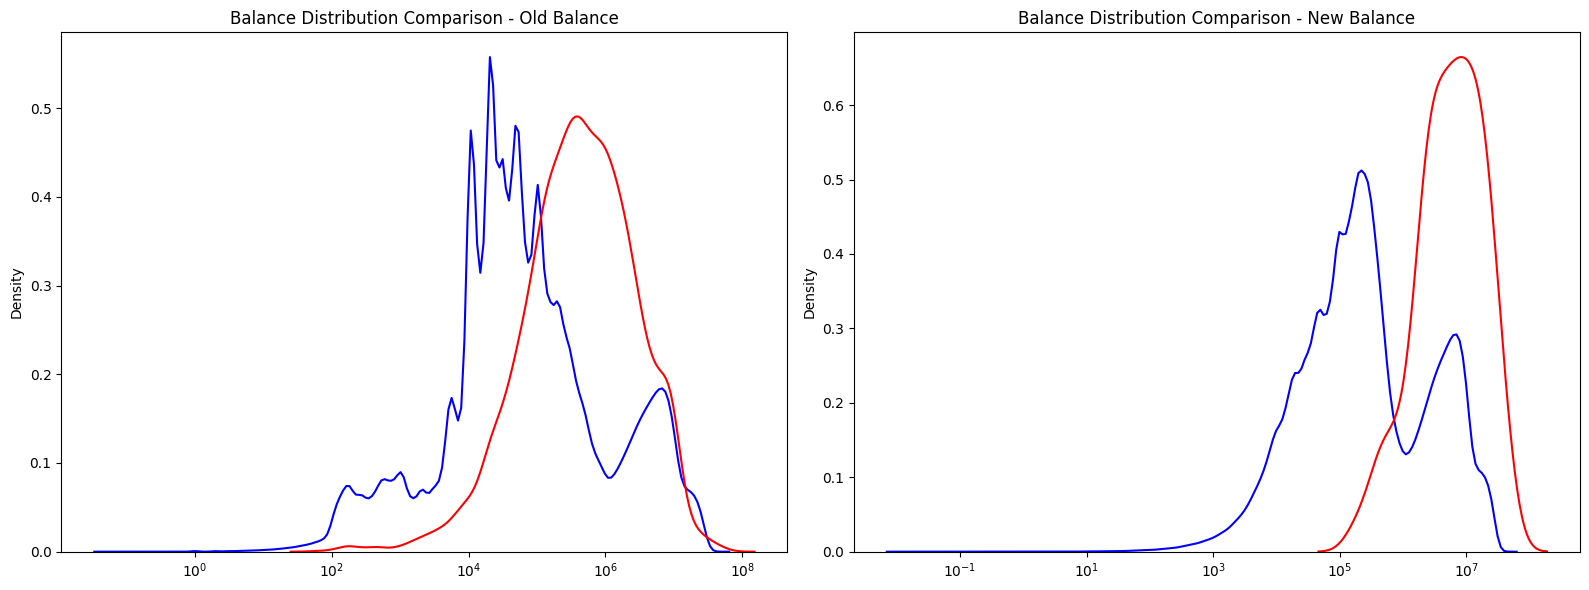

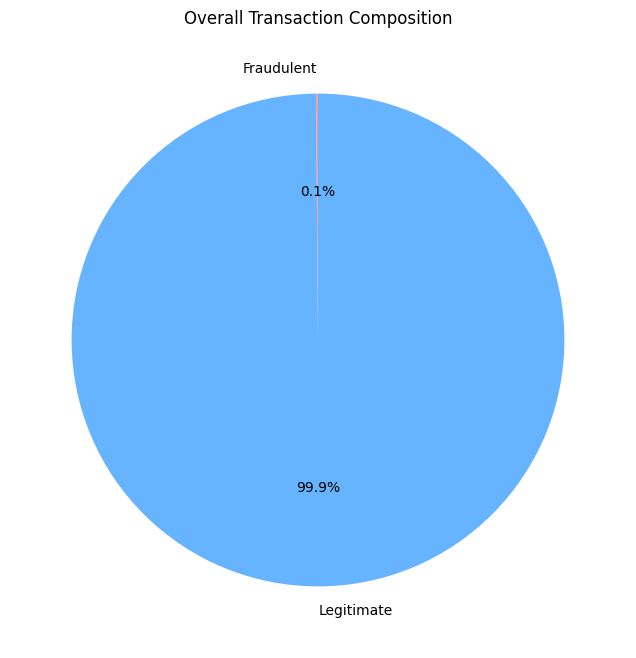


Cross-validation results (last 5 rows):
     train-error-mean  train-error-std  train-logloss-mean  train-logloss-std  \
767          0.002263         0.000137            0.012328           0.000157   
768          0.002262         0.000136            0.012281           0.000171   
769          0.002257         0.000138            0.012278           0.000185   
770          0.002256         0.000135            0.012260           0.000183   
771          0.002255         0.000135            0.012247           0.000160   

     test-error-mean  test-error-std  test-logloss-mean  test-logloss-std  
767         0.002300        0.000093           0.012488          0.000259  
768         0.002300        0.000093           0.012441          0.000293  
769         0.002293        0.000097           0.012439          0.000314  
770         0.002293        0.000094           0.012421          0.000301  
771         0.002292        0.000093           0.012409          0.000280  

Classification 

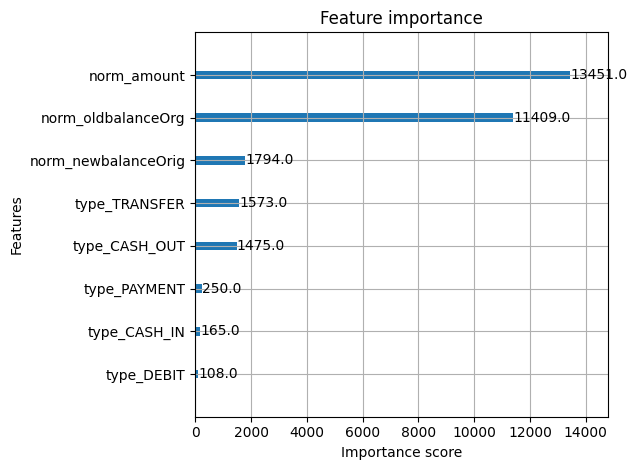

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
chunksize = 500_000
epsilon = 0.01
selected_types = ['TRANSFER', 'CASH_OUT', 'PAYMENT', 'CASH_IN', 'DEBIT']

# --- Preprocessing Setup: Collect global stats and categories ---
print("Collecting preprocessing statistics...")
all_types = set()
numeric_stats = {
    'amount': {'sum': 0, 'sum_sq': 0, 'count': 0},
    'oldbalanceOrg': {'sum': 0, 'sum_sq': 0, 'count': 0},
    'newbalanceOrig': {'sum': 0, 'sum_sq': 0, 'count': 0}
}

for chunk in pd.read_csv(r"D:\online payment\online_payment.csv", chunksize=chunksize):
    chunk = chunk.dropna(subset=['amount', 'isFraud'])
    chunk = chunk[chunk['amount'] > 0]
    all_types.update(chunk['type'].unique())

    for col in numeric_stats:
        vals = chunk[col].replace(0, epsilon)
        numeric_stats[col]['sum'] += vals.sum()
        numeric_stats[col]['sum_sq'] += (vals ** 2).sum()
        numeric_stats[col]['count'] += vals.count()

means = {col: stats['sum'] / stats['count'] for col, stats in numeric_stats.items()}
stds = {col: np.sqrt((stats['sum_sq'] / stats['count']) - (means[col] ** 2)) for col, stats in numeric_stats.items()}

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(pd.DataFrame({'type': list(all_types)}))

# Data structures for analysis and model data
accumulator = {}
amount_by_type = {}
data_collectors = {key: {'fraud': [], 'nonfraud': []} for key in ['amounts', 'steps', 'oldbalance', 'newbalance']}
X_list, y_list = [], []

print("\nProcessing data and collecting stats...")
for chunk in pd.read_csv(r"D:\online payment\online_payment.csv", chunksize=chunksize):
    chunk = chunk.drop(['isFlaggedFraud'], axis=1, errors='ignore')
    chunk = chunk.dropna(subset=['amount', 'isFraud'])
    chunk = chunk[chunk['amount'] > 0]
    if chunk.empty:
        continue
    chunk['isFraud'] = chunk['isFraud'].astype(int)
    analysis_chunk = chunk.copy()

    # One-hot encode type column
    type_enc = encoder.transform(chunk[['type']])
    cols_enc = encoder.get_feature_names_out(['type'])
    chunk = pd.concat([chunk, pd.DataFrame(type_enc, columns=cols_enc, index=chunk.index)], axis=1)

    # Clip zero balances
    for col in ['oldbalanceOrg', 'newbalanceOrig']:
        chunk[col] = chunk[col].clip(lower=epsilon)

    # Normalize numerical columns
    for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig']:
        chunk[f'norm_{col}'] = (chunk[col] - means[col]) / stds[col]

    # Update fraud statistics for EDA
    counts = analysis_chunk.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
    for tx_type in counts.index:
        fraud_count = counts.loc[tx_type].get(1, 0)
        total_count = counts.loc[tx_type].sum()
        if tx_type not in accumulator:
            accumulator[tx_type] = {'fraud_count': 0, 'total_count': 0}
        accumulator[tx_type]['fraud_count'] += fraud_count
        accumulator[tx_type]['total_count'] += total_count

    # Collect data for visualization
    mask_fraud = analysis_chunk['isFraud'] == 1
    for status in ['fraud', 'nonfraud']:
        mask = mask_fraud if status == 'fraud' else ~mask_fraud

        data_collectors['amounts'][status].extend(analysis_chunk.loc[mask, 'amount'].tolist())
        data_collectors['steps'][status].extend(analysis_chunk.loc[mask, 'step'].tolist())

        for balance_type in ['oldbalanceOrg', 'newbalanceOrig']:
            key = 'oldbalance' if balance_type == 'oldbalanceOrg' else 'newbalance'
            balance_filter = (analysis_chunk[balance_type] > 0)
            combined_mask = mask & balance_filter
            filtered = analysis_chunk.loc[combined_mask, balance_type]
            data_collectors[key][status].extend(filtered.tolist())

    # Collect amount by type for visualization (optional)
    for (tx_type, is_fraud), group in analysis_chunk.groupby(['type', 'isFraud']):
        if tx_type not in amount_by_type:
            amount_by_type[tx_type] = {'fraud': [], 'nonfraud': []}
        target = 'fraud' if is_fraud else 'nonfraud'
        amount_by_type[tx_type][target].extend(group['amount'].tolist())

    # Prepare data for model training
    feats = chunk[['norm_amount', 'norm_oldbalanceOrg', 'norm_newbalanceOrig', *cols_enc, 'step']]
    labels = chunk['isFraud']
    X_list.append(feats)
    y_list.append(labels)

# Combine samples for model
X = pd.concat(X_list, axis=0)
y = pd.concat(y_list, axis=0)
valid = y.notnull()
X, y = X.loc[valid], y.loc[valid]

# --- Visualization ---

# Fraud Rate by Transaction Type
fraud_stats = pd.DataFrame([
    {
        'type': tx_type,
        'fraud_rate': (stats['fraud_count'] / stats['total_count']) * 100
    }
    for tx_type, stats in accumulator.items()
    if stats['total_count'] > 0
])

filtered_stats = fraud_stats[fraud_stats['type'].isin(selected_types)]

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_stats, x='type', y='fraud_rate')
plt.title('Fraud Rate by Transaction Type (%)')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Transaction Type')
plt.show()

# Amount Distribution (Log scale)
plt.figure(figsize=(12, 6))
sns.histplot(data_collectors['amounts']['nonfraud'], color='blue',
             label='Non-Fraud', bins=100, stat='density',
             log_scale=True, alpha=0.5)
sns.histplot(data_collectors['amounts']['fraud'], color='red',
             label='Fraud', bins=100, stat='density',
             log_scale=True, alpha=0.7)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Amount (log scale)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Balance Distribution Comparison
def plot_balance_comparison(old_data, new_data, title_prefix):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    if len(old_data['nonfraud']) > 1 or len(old_data['fraud']) > 1:
        sns.kdeplot(old_data['nonfraud'], color='blue', label='Non-Fraud',
                    ax=ax[0], log_scale=True, warn_singular=False)
        sns.kdeplot(old_data['fraud'], color='red', label='Fraud',
                    ax=ax[0], log_scale=True, warn_singular=False)
        ax[0].set_title(f'{title_prefix} - Old Balance')
    else:
        ax[0].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center')

    if len(new_data['nonfraud']) > 1 or len(new_data['fraud']) > 1:
        sns.kdeplot(new_data['nonfraud'], color='blue', label='Non-Fraud',
                    ax=ax[1], log_scale=True, warn_singular=False)
        sns.kdeplot(new_data['fraud'], color='red', label='Fraud',
                    ax=ax[1], log_scale=True, warn_singular=False)
        ax[1].set_title(f'{title_prefix} - New Balance')
    else:
        ax[1].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center')

    plt.tight_layout()
    plt.show()

plot_balance_comparison(data_collectors['oldbalance'],
                       data_collectors['newbalance'],
                       'Balance Distribution Comparison')

# Fraud Prevalence Pie Chart
total_fraud = sum(v['fraud_count'] for v in accumulator.values())
total_legit = sum(v['total_count'] for v in accumulator.values()) - total_fraud

plt.figure(figsize=(8, 8))
plt.pie([total_fraud, total_legit],
        labels=['Fraudulent', 'Legitimate'],
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'],
        startangle=90)
plt.title('Overall Transaction Composition')
plt.show()

# --- Model Training with XGBoost ---

# Sort by 'step' and split time-wise (80/20)
idx = X.sort_values('step').index
split_idx = int(len(idx) * 0.8)

X_train = X.loc[idx[:split_idx]].drop('step', axis=1)
X_val = X.loc[idx[split_idx:]].drop('step', axis=1)
y_train = y.loc[idx[:split_idx]]
y_val = y.loc[idx[split_idx:]]

train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
val_dmatrix = xgb.DMatrix(data=X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 6,
    'eval_metric': 'error'
}

num_rounds = 1000
cv_results = xgb.cv(
    params=params,
    dtrain=train_dmatrix,
    num_boost_round=num_rounds,
    nfold=4,
    metrics=('error', 'logloss'),
    early_stopping_rounds=20,
    as_pandas=True,
    seed=42
)
print("\nCross-validation results (last 5 rows):")
print(cv_results.tail())

best_rounds = len(cv_results)

model = xgb.train(
    params=params,
    dtrain=train_dmatrix,
    num_boost_round=best_rounds
)

# Evaluation
preds = model.predict(val_dmatrix)
pred_labels = (preds > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_val, pred_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_val, pred_labels))

# Feature importance plot
xgb.plot_importance(model, max_num_features=10)
plt.tight_layout()
plt.show()